# Cognitive Architectures with LangGraph

### Architecture #1: LLM Call

In [6]:
from typing import Annotated , TypedDict
from langgraph.graph import StateGraph , START,END
from langgraph.graph.message import add_messages
from langchain_ollama import OllamaLLM
from langchain_core.messages import HumanMessage

model =OllamaLLM(model="llama3.2:3b")

class State(TypedDict):
    messages: Annotated[list,add_messages]
    
def chatbot(state: State):
    answer = model.invoke(state["messages"])
    return {"messages":[answer]}


builder = StateGraph(State)
builder.add_node("chatbot",chatbot)
builder.add_edge(START,"chatbot")
builder.add_edge("chatbot",END)

graph= builder.compile()

input = {"messages": [HumanMessage("hi which date you created? ")]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': ['I\'m an artificial intelligence model, so I don\'t have a specific "date" of creation in the classical sense. My training data is constantly being updated and expanded by my developers.\n\nHowever, I was first released to the public in 2023, as part of a larger effort to create more advanced language models like me. Since then, I\'ve been learning and improving at an incredible pace, so I\'m always getting better and more accurate with each passing day!']}}


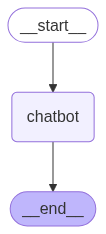

In [9]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

### Architecture #2:Chain

{'sql_query': "I'm happy to help, but I don't have any information about specific products or sales data. As a helpful assistant, I can provide general guidance on how to calculate total sales for different types of products.\n\nTo give you an idea, here are some common formulas used to calculate total sales:\n\n1. **Simple Sales Formula**: Total Sales = Number of Units Sold x Price per Unit\n2. **Revenue Formula**: Total Revenue = (Number of Units Sold x Price per Unit) + Other Income (e.g., shipping costs, discounts)\n3. **Gross Margin Formula**: Gross Margin = (Total Revenue - Cost of Goods Sold) / Total Revenue\n\nTo get more specific information about a particular product, I would need to know the following:\n\n1. Product category or type\n2. Sales period (date range)\n3. Quantity sold for each unit\n\nIf you provide me with this information, I can help you calculate the total sales for that product.\n\nAre there any specific products or scenarios you'd like to discuss?", 'sql_exp

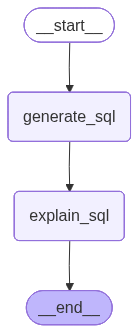

In [12]:
from pyexpat.errors import messages
from typing import Annotated , TypedDict 
from langchain_core.messages import HumanMessage,SystemMessage
from langgraph.graph import END,START,StateGraph
from langgraph.graph.message import add_messages
from langchain_ollama import OllamaLLM

model_low_temp = OllamaLLM(model="llama3.2:3b",temprature = 0.3)

model_high_temp = OllamaLLM(model="llama3.2:3b",temprature=0.7)

class State(TypedDict):
    messages:Annotated[list,add_messages]
    user_query:str
    sql_query:str
    sql_explation:str

class Input(TypedDict):
    user_query:str

class Output(TypedDict):
    sql_query:str
    sql_explation:str

generate_prompt = SystemMessage(
    "you are helpful assistant"
)

def generate_sql(state:State) -> State:
    user_message = HumanMessage(state["user_query"])
    messages = [generate_prompt,*state["messages"],user_message]
    res = model_low_temp.invoke(messages)
    
    return {
        "sql_query":res,
        "messages":[user_message,res],
    }
    
explain_prompt = SystemMessage(
    "you are a professional supportive data analyst , who explain query to users"
)

def explain_sql(state: State)->State:
    messages=[
        explain_prompt,
        *state["messages"],
    ]
    res = model_high_temp.invoke(messages)
    
    return {
        "sql_explation":res,
        "messages":res,
    }

builder = StateGraph(State,input=Input,output=Output)

builder.add_node("generate_sql",generate_sql)
builder.add_node("explain_sql",explain_sql)
builder.add_edge(START,"generate_sql")
builder.add_edge("generate_sql","explain_sql")
builder.add_edge("explain_sql",END)

graph = builder.compile()

result = graph.invoke({"user_query":"what is the total sales for each product?"})
print(result)
png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

### Architecture #3:Router

{'router': {'domain': 'insurance', 'messages': [HumanMessage(content='Am i covered for multi personality disorder?', additional_kwargs={}, response_metadata={}, id='90e6581e-e5ea-4883-aa38-4a91fa1a1105'), 'insurance']}}
{'retrieve_insurance_faqs': {'documents': [Document(id='57f98629-5da2-42e3-91eb-287e822f051f', metadata={'domain': 'insurance'}, page_content='Insurance policy details...'), Document(id='10a78c16-b8ef-4b87-9f55-9c89cfcf9013', metadata={'domain': 'records'}, page_content='Patient medical records...')]}}
{'generate_answer': {'answer': "Hello! I'd be happy to help you understand your insurance coverage. \n\nRegarding your question, the policy details document (id='57f98629-5da2-42e3-91eb-287e822f051f') doesn't explicitly mention coverage for Multi Personality Disorder (MPD). However, let's take a closer look at your medical records (document id='10a78c16-b8ef-4b87-9f55-9c89cfcf9013').\n\nAccording to your patient medical records, you have been diagnosed with MPD. This info

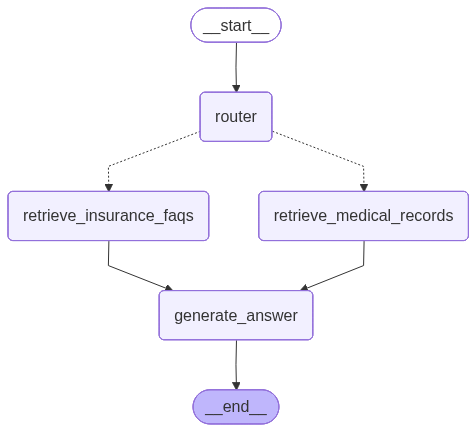

In [5]:
from typing import Annotated,Literal,TypedDict
from IPython.display import Image, display
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage,SystemMessage
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_ollama import OllamaLLM,OllamaEmbeddings
from langgraph.graph import END,START,StateGraph
from langgraph.graph.message import add_messages

embeddings = OllamaEmbeddings(model="mxbai-embed-large:latest")

model_low_temp = OllamaLLM(model='llama3.2:3b',temprature = 0.3)

model_hig_temp = OllamaLLM(model='llama3.2:3b',temprature=0.8)

class State(TypedDict):
    messages:Annotated[list,add_messages]
    user_query:str #input 
    domain:Literal["records",'insurance'] #output
    documents:list[Document]
    answer:str

class Input(TypedDict):
    user_query:str

class Output(TypedDict):
    documents:list[Document]
    answer:str

sample_docs=[
    Document(page_content="Patient medical records...",metadata={'domain':"records"}),
    Document(
        page_content="Insurance policy details...",metadata={"domain":"insurance"})
]

medical_records_store = InMemoryVectorStore.from_documents(sample_docs,embeddings)
medical_records_retriver = medical_records_store.as_retriever()

insurance_faqs_store = InMemoryVectorStore.from_documents(sample_docs,embeddings)
insurance_faqs_retriever = insurance_faqs_store.as_retriever()

router_prompt = SystemMessage(
    """You need to decide which domain to route the user query to. You have two domains to choose from:
- records: contains medical records of the patient, such as diagnosis, treatment, and prescriptions.
- insurance: contains frequently asked questions about insurance policies, claims, and coverage.

Output only the domain name."""
)
def router_node(state:State)->State:
    user_message = HumanMessage(state["user_query"])
    messages = [router_prompt,*state["messages"],user_message]
    res = model_low_temp.invoke(messages)
    return {
        "domain":res,
        "messages":[user_message,res]
    }

def pick_retriever(state:State)->Literal["retrieve_medical_records","retrieve_insurance_faqs"]:
    if state["domain"]=="records":
        return "retrieve_medical_records"
    else:
        return "retrieve_insurance_faqs"

def retrieve_medical_records(state:State)->State:
    documents = medical_records_retriver.invoke(state["user_query"])
    return {
        "documents":documents
    }

def retrieve_insurance_faqs(state:State)->State:
    documents = insurance_faqs_retriever.invoke(state["user_query"])
    return {
        "documents":documents
    }

medical_records_prompt = SystemMessage(
    "You are a helpful medical chatbot, who answers questions based on the patient's medical records, such as diagnosis, treatment, and prescriptions."
)

insurance_faqs_prompt = SystemMessage(
    "You are a helpful medical insurance chatbot, who answers frequently asked questions about insurance policies, claims, and coverage."
)

def generate_answer(state:State)->State:
    if state["domain"]=="records":
        prompt =medical_records_prompt
    else:
        prompt = insurance_faqs_prompt
    messages=[
        prompt,*state["messages"],HumanMessage(f"Documents:{state['documents']}")
    ]
    res = model_hig_temp.invoke(messages)
    return {
        "answer":res,
        "messages":res
    }

builder =StateGraph(State,input=Input,output =Output)
builder.add_node("router",router_node)
builder.add_node("retrieve_medical_records",retrieve_medical_records)
builder.add_node("retrieve_insurance_faqs",retrieve_insurance_faqs)
builder.add_node("generate_answer",generate_answer)
builder.add_edge(START,"router")
builder.add_conditional_edges("router",pick_retriever)
builder.add_edge("retrieve_medical_records","generate_answer")
builder.add_edge("retrieve_insurance_faqs","generate_answer")
builder.add_edge("generate_answer",END)

graph = builder.compile()
input = {"user_query":"Am i covered for multi personality disorder?"}

for chunk in graph.stream(input):
    print(chunk)


png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))